# Google Colab / Kaggle / PC

In [1]:
mode = "Colab"

In [2]:
import os

if mode == "Colab":
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/FPL_ML")
    TRAIN_PATH = "data/final_dataset.csv"
if mode == "PC":
    os.chdir("D:\PulpitE\FPL_ML")
    TRAIN_PATH = "data/final_dataset.csv"
if mode == "Kaggle":
    TRAIN_PATH = "/kaggle/input/fpl-dataset/final_dataset.csv"

Mounted at /content/gdrive


# Imports

In [3]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random

# Constants and seeds

In [4]:
# FIXTURES_IN_SAMPLE
FIS = 8

# FIXTURES_FOR_PLAYER - minimal number of gameweeks required for a player
FFP = 15

FIRST_TRAIN_GW = 1
LAST_TRAIN_GW = 20

FIRST_VALID_GW = 21
LAST_VALID_GW = 21

# NEXT_GAMEWEEK = 22
# LAST_GAMEWEEK = NEXT_GAMEWEEK - 1

In [5]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(42)

# Device

In [6]:
device = torch.device("cuda")
# device = torch.device('mps')
# device = torch.device('cpu')

# Getting data and choosing features

In [7]:
df = pd.read_csv('data/final_dataset.csv')

In [8]:
# remembering original dataframes
df_original = df

df_gk_original = df[df["FPL position"] == "GK"]
df_def_original = df[df["FPL position"] == "DEF"]
df_mid_original = df[df["FPL position"] == "MID"]
df_fwd_original = df[df["FPL position"] == "FWD"]

In [9]:
# df_original.columns

In [10]:
info = ["Name", "GW", "FPL position"]
other = ["LSTM"]
features = ["Min", "Gls", "Ast", "Sh", "SoT", "xG", "npxG", "xAG", "SCA", "GCA", "CS", "CrdY", "CrdR", "Opp rating", "Team Score", "Opp Score", "Was Home"]
to_predict = ["Total Points"]

In [11]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [12]:
df.shape

(7457, 21)

In [13]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')

# taking only players with at least FFP matches in logs
df = grouped.filter(lambda x: len(x) >= FFP)

In [14]:
df.shape

(5771, 21)

In [15]:
# df.head(20)

In [16]:
last_names = df["Name"].unique()

# DF to DataLoader

In [17]:
df_train = df[df["GW"] <= LAST_TRAIN_GW]
df_valid = df

# gk, def, mid, fwd
df_gk_train = df[(df["FPL position"] == "GK") & (df["GW"] <= LAST_TRAIN_GW)]
df_gk_valid = df[(df["FPL position"] == "GK") ]

df_def_train = df[(df["FPL position"] == "DEF") & (df["GW"] <= LAST_TRAIN_GW)]
df_def_valid = df[(df["FPL position"] == "DEF") ]

df_mid_train = df[(df["FPL position"] == "MID") & (df["GW"] <= LAST_TRAIN_GW)]
df_mid_valid = df[(df["FPL position"] == "MID") ]

df_fwd_train = df[(df["FPL position"] == "FWD") & (df["GW"] <= LAST_TRAIN_GW)]
df_fwd_valid = df[(df["FPL position"] == "FWD")]

In [18]:
def init_index_table(df):
    names = df["Name"].unique()
    result_dict = {}
    
    current_index = 0
    player_index = 0
    
    for name in names:
        sample_index = 0
        samples_for_names = df[df["Name"] == name].shape[0] - FIS
        for i in range(samples_for_names):
            result_dict[current_index] = [player_index, sample_index]
            current_index += 1
            sample_index += 1
        player_index += 1
    
    return result_dict

In [19]:
class PandasDataset(Dataset):
    def __init__(self, dataframe, starting_gw, ending_gw):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        
        self.starting_gw = starting_gw
        self.ending_gw = ending_gw
        self.cut_unused_rows()
        self.length = self.calculate_length()

        self.index_table = init_index_table(self.dataframe)
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def cut_unused_rows(self):
        for name in self.names:
            df_name = self.dataframe[self.dataframe["Name"] == name]
            name_length = df_name.shape[0]
            # print("NAME LENGTH", name, name_length, FIS + 1)
            if name_length >= FIS + 1:
                try:
                    first_index = df_name.index.tolist()[0]
                except IndexError:
                    first_index = None

                try:
                    last_index = max(FIS, df_name.index[df_name['GW'] < self.starting_gw].tolist()[-1]) - FIS
                except:
                    last_index = None

                # print("FIRST LAST INDEX", name, first_index, last_index)
                if first_index != None and last_index != None:
                    # print("WYCIETO", name, range(first_index, last_index + 1))
                    self.dataframe = self.dataframe.drop(range(first_index, last_index + 1))
            else:
                # print("DROPPING", name, [df_name.index.tolist()])
                self.dataframe = self.dataframe.drop([df_name.index.tolist()])
                

            # print("CUTTING", name, first_index, last_index, name_length)
            # print("CUT2", df_name.index[df_name['GW'] < self.starting_gw].tolist())
            # print(self.dataframe.shape)
            # print("")

    def calculate_length(self):
        length = 0
        for name in self.names:
            # print(name, (self.dataframe[self.dataframe["Name"] == name].shape[0] - FIS))
            length += (self.dataframe[self.dataframe["Name"] == name].shape[0] - FIS)
        return length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # print(idx)
        player_id, sample_id = self.index_table[idx]
        name = self.names[player_id]
        # print(name)
        # print("GETITEM DF", name, player_id, sample_id)

        features = self.dataframe[self.dataframe["Name"] == name]
        # print(self.dataframe[self.dataframe["Name"] == name])
        # print(features[sample_id: (sample_id + 4)])
        features = features[sample_id: (sample_id + FIS)].drop(columns=info).values[:, :-1]
        # print(features)
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        # print("GETITEM", idx, player_id, sample_id, name)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[(sample_id + FIS), -1])
        # print(name, idx, target, sample_id)
        # print(type(target))
        return features, target

In [20]:
dataset_general_train = PandasDataset(df_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_general_valid = PandasDataset(df_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_gk_train = PandasDataset(df_gk_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_gk_valid = PandasDataset(df_gk_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_def_train = PandasDataset(df_def_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_def_valid = PandasDataset(df_def_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_mid_train = PandasDataset(df_mid_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_mid_valid = PandasDataset(df_mid_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_fwd_train = PandasDataset(df_fwd_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_fwd_valid = PandasDataset(df_fwd_valid, FIRST_VALID_GW, LAST_VALID_GW)

In [21]:
dataset_gk_train.__len__(), dataset_gk_valid.__len__()

(280, 25)

In [22]:
dataset_def_train.__len__(), dataset_def_valid.__len__()

(1035, 100)

In [23]:
dataset_mid_train.__len__(), dataset_mid_valid.__len__()

(1346, 123)

In [24]:
dataset_fwd_train.__len__(), dataset_fwd_valid.__len__()

(326, 30)

In [25]:
batch_size = 16

In [26]:
dataloader_general_train = DataLoader(dataset_general_train, batch_size=batch_size, shuffle=False)
dataloader_general_valid = DataLoader(dataset_general_valid, batch_size=batch_size, shuffle=False)

dataloader_gk_train = DataLoader(dataset_gk_train, batch_size=batch_size, shuffle=False)
dataloader_def_train = DataLoader(dataset_def_train, batch_size=batch_size, shuffle=False)
dataloader_mid_train = DataLoader(dataset_mid_train, batch_size=batch_size, shuffle=False)
dataloader_fwd_train = DataLoader(dataset_fwd_train, batch_size=batch_size, shuffle=False)

dataloader_gk_valid = DataLoader(dataset_gk_valid, batch_size=batch_size, shuffle=False)
dataloader_def_valid = DataLoader(dataset_def_valid, batch_size=batch_size, shuffle=False)
dataloader_mid_valid = DataLoader(dataset_mid_valid, batch_size=batch_size, shuffle=False)
dataloader_fwd_valid = DataLoader(dataset_fwd_valid, batch_size=batch_size, shuffle=False)

In [27]:
len(dataloader_general_train), len(dataloader_gk_train), len(dataloader_def_train), len(dataloader_mid_train), len(dataloader_fwd_train)

(187, 18, 65, 85, 21)

In [28]:
len(dataloader_general_valid), len(dataloader_gk_valid), len(dataloader_def_valid), len(dataloader_mid_valid), len(dataloader_fwd_valid)

(18, 2, 7, 8, 2)

# LSTM Model

In [29]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        # x = x.view(-1, batch_size)
        # x = torch.transpose(x, 0, 1)
        # print("FOR", x.shape)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

# Training loops

In [30]:
criterion = nn.MSELoss()

In [31]:
def train_net(net, num_epochs, dataloader_train, dataloader_valid, optimizer):
    if len(dataloader_train) <= 0:
        print("Dataloader has no elements")
        return []

    best_model = None
    best_val_loss = None

    loss_history_train = []
    loss_history_valid = []

    for epoch in range(num_epochs):
        running_loss_train = 0
        running_loss_valid = 0

        # training
        for i, (inputs, targets) in enumerate(dataloader_train):
            inputs = torch.flatten(inputs, 1, 2)
            inputs = inputs.unsqueeze(2).to(device)
            targets = targets.to(device)
            # print("INPUTS", inputs.shape)
            # print("TARGETS", targets.shape)
            # print(targets)
            optimizer.zero_grad()
            outputs = net(inputs).flatten().to(device)
            # print("OUTPUTS", outputs.shape)
            loss = criterion(outputs, targets)
            running_loss_train += loss.item()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
          # valid
          for i, (inputs, targets) in enumerate(dataloader_valid):
              inputs = torch.flatten(inputs, 1, 2)
              inputs = inputs.unsqueeze(2).to(device)
              targets = targets.to(device)
              # print("INPUTS", inputs.shape)
              # print("TARGETS", targets.shape)
              # print(targets)
              optimizer.zero_grad()
              outputs = net(inputs).flatten().to(device)
              # print("OUTPUTS", outputs.shape)
              loss = criterion(outputs, targets)
              running_loss_valid += loss.item()

        epoch_valid_loss = running_loss_valid / len(dataloader_valid)

        loss_history_train.append(running_loss_train / len(dataloader_train))
        loss_history_valid.append(epoch_valid_loss)

        if not best_model or epoch_valid_loss < best_val_loss:
            best_model = net
            best_val_loss = epoch_valid_loss


        if epoch % 5 == 0:
            print(f'Epoch {epoch} Train: {running_loss_train / len(dataloader_train)} Valid: {running_loss_valid / len(dataloader_valid)}')
    
    return loss_history_train, loss_history_valid, best_model

In [32]:
def plot_loss_history(loss_history_train, loss_history_valid):
    plt.plot(loss_history_train, color='blue', label='Training Loss')
    plt.plot(loss_history_valid, color='orange', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Training loop - general net

In [33]:
%%time
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.005)
loss_history_train, loss_history_valid, best_model_general = train_net(net, 10, dataloader_general_train, dataloader_general_valid, optimizer)

Epoch 0 Train: 9.059177205524342 Valid: 8.710018104977078
Epoch 5 Train: 8.82690004677696 Valid: 8.724292172325981
CPU times: user 1min 7s, sys: 2.2 s, total: 1min 9s
Wall time: 1min 15s


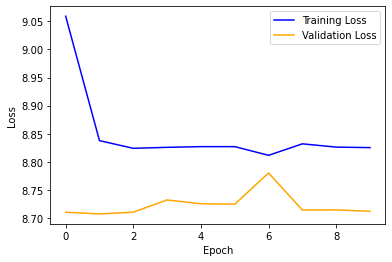

In [34]:
plot_loss_history(loss_history_train, loss_history_valid)

## Training loop - goalkeeper net

In [35]:
net_gk = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [36]:
%%time
optimizer_gk = optim.Adam(net_gk.parameters(), lr=0.01)
loss_history_gk_train, loss_history_gk_valid, best_model_gk = train_net(net_gk, 5, dataloader_gk_train, dataloader_gk_valid, optimizer_gk)

Epoch 0 Train: 13.226041197776794 Valid: 13.61018180847168
CPU times: user 2.58 s, sys: 19.1 ms, total: 2.6 s
Wall time: 2.65 s


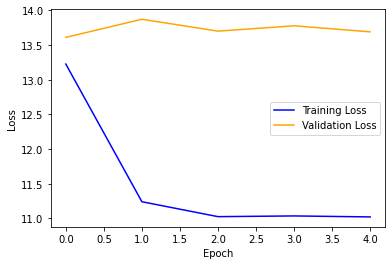

In [37]:
plot_loss_history(loss_history_gk_train, loss_history_gk_valid)

## Training loop - defender net

In [38]:
net_def = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [39]:
%%time
optimizer_def = optim.Adam(net_def.parameters(), lr=0.005)
loss_history_def_train, loss_history_def_valid, best_model_def = train_net(net_def, 5, dataloader_def_train, dataloader_def_valid, optimizer_def)

Epoch 0 Train: 8.86055102944374 Valid: 7.333229746137347
CPU times: user 8.63 s, sys: 97.7 ms, total: 8.72 s
Wall time: 8.6 s


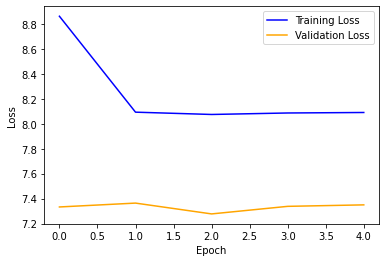

In [40]:
plot_loss_history(loss_history_def_train, loss_history_def_valid)

## Training loop - midfielder net

In [41]:
net_mid = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [42]:
%%time
optimizer_mid = optim.Adam(net_mid.parameters(), lr=0.005)
loss_history_mid_train, loss_history_mid_valid, best_model_mid = train_net(net_mid, 300, dataloader_mid_train, dataloader_mid_valid, optimizer_mid)

Epoch 0 Train: 9.194421863555908 Valid: 6.260515183210373
Epoch 5 Train: 8.593121256547816 Valid: 5.880041122436523
Epoch 10 Train: 8.587371692937964 Valid: 5.858483821153641
Epoch 15 Train: 8.584014125431285 Valid: 5.811483711004257
Epoch 20 Train: 8.584341486762552 Valid: 5.815948963165283
Epoch 25 Train: 8.585866552240708 Valid: 5.81481745839119
Epoch 30 Train: 8.584877862649805 Valid: 5.8116037249565125
Epoch 35 Train: 8.585177573035745 Valid: 5.814336955547333
Epoch 40 Train: 8.585010598687564 Valid: 5.810986816883087
Epoch 45 Train: 8.58487008038689 Valid: 5.807478845119476
Epoch 50 Train: 8.584576171987196 Valid: 5.807720810174942
Epoch 55 Train: 8.584937679066378 Valid: 5.807906001806259
Epoch 60 Train: 8.585226248292361 Valid: 5.808498531579971
Epoch 65 Train: 8.584133913937738 Valid: 5.808030813932419
Epoch 70 Train: 8.58448944793028 Valid: 5.806978017091751
Epoch 75 Train: 8.584123408093172 Valid: 5.807606369256973
Epoch 80 Train: 8.584669160842896 Valid: 5.806559503078461
E

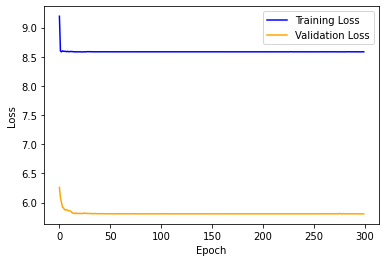

In [43]:
plot_loss_history(loss_history_mid_train, loss_history_mid_valid)

## Training loop - forward net

In [44]:
net_fwd = LSTMNetwork(1, 8, 2, 1, dropout=0.5).to(device)

In [45]:
%%time
optimizer_fwd = optim.Adam(net_fwd.parameters(), lr=0.001)
loss_history_fwd_train, loss_history_fwd_valid, best_model_fwd = train_net(net_fwd, 500, dataloader_fwd_train, dataloader_fwd_valid, optimizer_fwd)

Epoch 0 Train: 18.015597587540036 Valid: 24.0992431640625
Epoch 5 Train: 12.17596955242611 Valid: 17.230422973632812
Epoch 10 Train: 10.650105998629616 Valid: 15.105846405029297
Epoch 15 Train: 10.506284520739602 Valid: 15.110828876495361
Epoch 20 Train: 10.517813932327996 Valid: 14.95263147354126
Epoch 25 Train: 10.502878995168777 Valid: 14.753342628479004
Epoch 30 Train: 10.506467773800804 Valid: 14.902034759521484
Epoch 35 Train: 10.525084881555467 Valid: 14.577059268951416
Epoch 40 Train: 10.481941575095767 Valid: 14.854396343231201
Epoch 45 Train: 10.07554114432562 Valid: 14.238562107086182
Epoch 50 Train: 10.007211174283709 Valid: 13.949094772338867
Epoch 55 Train: 10.476406892140707 Valid: 14.862517833709717
Epoch 60 Train: 10.522292670749483 Valid: 14.876044750213623
Epoch 65 Train: 10.422967683701287 Valid: 14.861120223999023
Epoch 70 Train: 10.572334210077921 Valid: 14.815659999847412
Epoch 75 Train: 10.474939789090838 Valid: 14.981014728546143
Epoch 80 Train: 10.477815741584

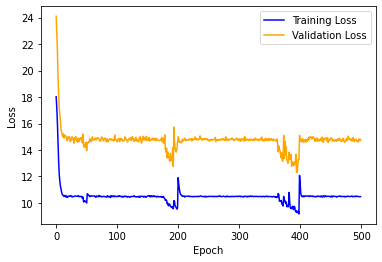

In [46]:
plot_loss_history(loss_history_fwd_train, loss_history_fwd_valid)

# Saving models to files

In [47]:
# general model
torch.save(net.state_dict(), 'models/regular/lstm_general.pt')

# positional models
torch.save(net_gk.state_dict(), 'models/regular/lstm_gk.pt')
torch.save(net_def.state_dict(), 'models/regular/lstm_def.pt')
torch.save(net_mid.state_dict(), 'models/regular/lstm_mid.pt')
torch.save(net_fwd.state_dict(), 'models/regular/lstm_fwd.pt')

# best models
torch.save(best_model_general.state_dict(), 'models/best/best_lstm_general.pt')
torch.save(best_model_gk.state_dict(), 'models/best/best_lstm_gk.pt')
torch.save(best_model_def.state_dict(), 'models/best/best_lstm_def.pt')
torch.save(best_model_mid.state_dict(), 'models/best/best_lstm_mid.pt')
torch.save(best_model_fwd.state_dict(), 'models/best/best_lstm_fwd.pt')

# Predictions - general model

In [48]:
def generate_predictions(dataloader_pos, dataset_pos, net_pos, df_original, first_gw):
    index = 0
    predictions_pos = []
    for inputs, target in dataloader_pos:
        inputs = torch.flatten(inputs, 1, 2)
        inputs = inputs.unsqueeze(2).to(device)

        # print("Inputs", inputs)
        # print("Target", target)
        # print("INPUTS", inputs)
        # print(inputs)
        outputs = net_pos(inputs).to(device)
        # print("OUTPUTS", outputs)
        for output in outputs:
            player_id, sample_id = dataset_pos.index_table[index]
            name = dataset_pos.names[player_id]
            points = round(output.item(), 2)
            # print("DFORW NEXT", player_id, sample_id, name, points)
            df_row = df_original[(df_original["Name"] == name) & (df_original["GW"] >= first_gw)].iloc[sample_id]
            # print("DFROW", df_row)
            df_row["Points"] = points
            df_gw = df_row["GW"]
            df_opp = df_row["Opponent"]

            # print("GEN PRED", player_id, sample_id, name, points, df_gw, df_opp)
            
            gw = sample_id + FIS + 1 # wrong
            predictions_pos.append(df_row)
            # df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points
            index += 1
    
    output_df = pd.DataFrame(predictions_pos)
    output_df = output_df.loc[:, ~output_df.columns.str.contains('^Unnamed')]
    return output_df

In [49]:
prediction_columns = ["Name", "GW", "Opponent", "Was Home", "Total Points", "Points"]

In [50]:
predictions = generate_predictions(dataloader_general_valid, dataset_general_valid, net, df_original, FIRST_VALID_GW)

In [51]:
# dataset_general_valid.__getitem__(279)

In [52]:
predictions.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
2100,Anthony-Elanga,21,Arsenal,0.0,0.0,2.83
3663,Kalidou-Koulibaly,21,Liverpool,0.0,0.0,2.83
543,Jordan-Ayew,21,Newcastle Utd,1.0,3.0,2.83
5066,Robin-Olsen,21,Southampton,0.0,0.0,2.83
3979,Diego-Llorente,21,Brentford,1.0,0.0,2.83
766,Said-Benrahma,21,Everton,1.0,3.0,2.83
6170,Ryan-Sessegnon,21,Fulham,0.0,0.0,2.83
1247,Calum-Chambers,21,Southampton,0.0,0.0,2.83
3381,Ben-Johnson,21,Everton,1.0,1.0,2.82
3325,Mathias-Jensen,21,Leeds United,0.0,3.0,2.82


In [53]:
# # appending results to original df
# for df_gw, df_opp, name, gw, points in predictions:
#     df_original.loc[(df_original["Name"] == name) & (df["GW"] == gw), "LSTM"] = points

In [54]:
# df_original.to_csv("data/fpl_fbref_elo_lstm.csv")

# Predictions for each position

## Goalkeepers

In [55]:
predictions_gk = generate_predictions(dataloader_gk_valid, dataset_gk_valid, net_gk, df_gk_original, FIRST_VALID_GW)

In [56]:
# results sorted
predictions_gk.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
675,Gavin-Bazunu,21,Aston Villa,1.0,3.0,3.13
2558,David-de-Gea,21,Arsenal,0.0,1.0,3.10
3862,Bernd-Leno,21,Tottenham,1.0,2.0,3.10
2409,Fraser-Forster,21,Fulham,0.0,0.0,3.10
7030,Danny-Ward,21,Brighton,1.0,1.0,3.09
5863,Jose-Sa,21,Manchester City,0.0,2.0,3.09
467,Kepa-Arrizabalaga,21,Liverpool,0.0,9.0,3.08
3052,Wayne-Hennessey,21,Bournemouth,0.0,2.0,3.07
214,Alisson,21,Chelsea,1.0,9.0,3.07
5066,Robin-Olsen,21,Southampton,0.0,0.0,3.05


## Defenders

In [57]:
predictions_def = generate_predictions(dataloader_def_valid, dataset_def_valid, net_def, df_def_original, FIRST_VALID_GW)

In [58]:
# results sorted
predictions_def.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
577,Cesar-Azpilicueta,21,Liverpool,0.0,1.0,2.38
5291,Ivan-Perisic,21,Fulham,0.0,6.0,2.38
1480,Vladimir-Coufal,21,Everton,1.0,6.0,2.38
4143,Harry-Maguire,21,Arsenal,0.0,0.0,2.37
1547,Marc-Cucurella,21,Liverpool,0.0,6.0,2.37
2659,Toti-Gomes,21,Manchester City,0.0,0.0,2.37
869,Sven-Botman,21,Crystal Palace,0.0,6.0,2.37
5782,Mads-Roerslev,21,Leeds United,0.0,6.0,2.36
2202,Pervis-Estupinan,21,Leicester City,0.0,9.0,2.36
2678,Joe-Gomez,21,Chelsea,1.0,7.0,2.36


## Midfielders

In [59]:
predictions_mid = generate_predictions(dataloader_mid_valid, dataset_mid_valid, net_mid, df_mid_original, FIRST_VALID_GW)

In [60]:
# results sorted
predictions_mid.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
18,Brenden-Aaronson,21,Brentford,1.0,3.0,2.91
4211,Orel-Mangala,21,Bournemouth,0.0,1.0,2.91
4824,Jacob-Murphy,21,Crystal Palace,0.0,1.0,2.91
4790,Joao-Moutinho,21,Manchester City,0.0,1.0,2.91
4763,Mason-Mount,21,Liverpool,0.0,3.0,2.91
4701,Kaoru-Mitoma,21,Leicester City,0.0,10.0,2.91
4642,James-Milner,21,Chelsea,1.0,2.0,2.91
4627,Luka-Milivojevic,21,Newcastle Utd,1.0,0.0,2.91
4566,Nampalys-Mendy,21,Brighton,1.0,2.0,2.91
4517,Scott-McTominay,21,Arsenal,0.0,2.0,2.91


## Forwards

In [61]:
predictions_fwd = generate_predictions(dataloader_fwd_valid, dataset_fwd_valid, net_fwd, df_fwd_original, FIRST_VALID_GW)

In [62]:
# results sorted
predictions_fwd.sort_values(by=["Points"], ascending = False).head(30)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
2904,Erling-Haaland,21,Wolves,1.0,17.0,2.76
6959,Carlos-Vinicius,21,Tottenham,1.0,1.0,2.76
1569,Patson-Daka,21,Brighton,1.0,1.0,2.76
4382,Jean-Philippe-Mateta,21,Newcastle Utd,1.0,1.0,2.75
6893,Jamie-Vardy,21,Brighton,1.0,2.0,2.75
3205,Kelechi-Iheanacho,21,Brighton,1.0,0.0,2.75
38,Che-Adams,21,Aston Villa,1.0,2.0,2.74
4443,Bryan-Mbeumo,21,Leeds United,0.0,2.0,2.71
7212,Callum-Wilson,21,Crystal Palace,0.0,2.0,2.71
7121,Danny-Welbeck,21,Leicester City,0.0,2.0,2.70
